# Assignment 2 : Choose Your Own Analysis

## Reddit Data Pre-processing and Exploration

### Look at Amount of Data and Time Range of Reddit Data


📊 Subreddit Statistics:
• r/ChatGPTPro: 943 posts | 16730 comments | Range: 2025-04-04 → 2025-05-18
• r/ChatGPTPromptGenius: 877 posts | 6681 comments | Range: 2025-04-14 → 2025-05-16
• r/LocalLLaMA: 944 posts | 21607 comments | Range: 2025-05-02 → 2025-05-18
• r/PromptEngineering: 940 posts | 7620 comments | Range: 2025-03-17 → 2025-05-20

📌 Overall Date Range: 2025-03-17 → 2025-05-20
🧮 Total posts: 3704
💬 Total comments: 52638
📦 Total items (posts + comments): 56342


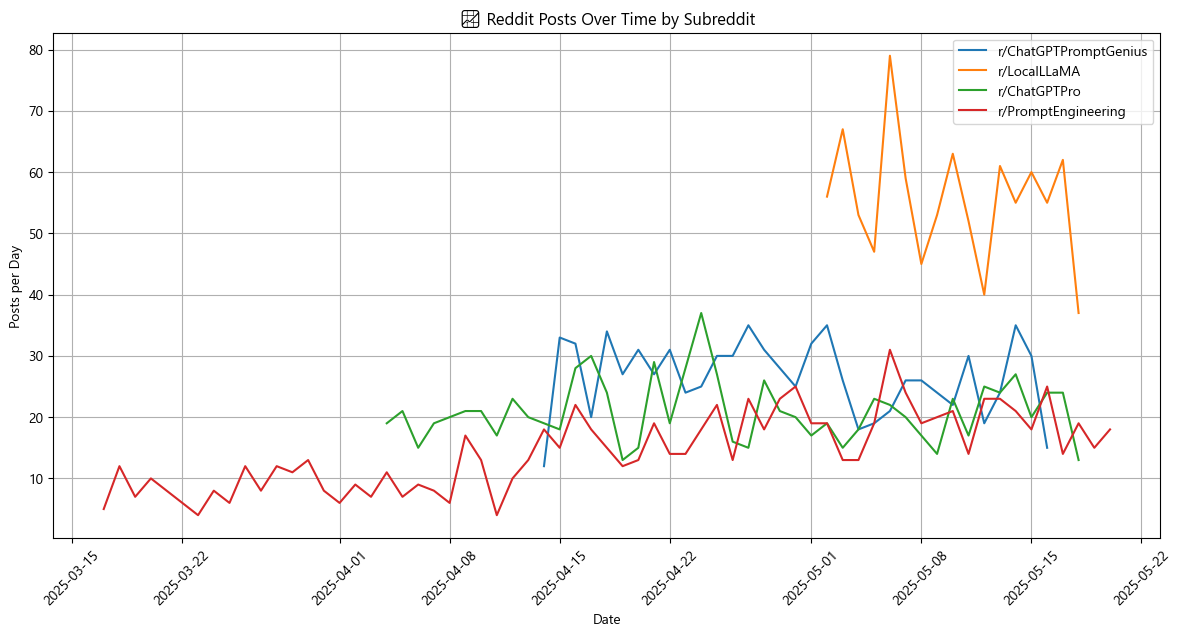

In [1]:
import json
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from matplotlib.dates import DateFormatter

plt.rcParams['font.family'] = 'Segoe UI Emoji'

# --- Load Data ---
with open("reddit_promptengineering.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# --- Organize Data ---
dates_by_subreddit = defaultdict(list)
post_counts = defaultdict(int)
comment_counts = defaultdict(int)
all_dates = []

for post in data:
    created_at = datetime.fromtimestamp(post["created_utc"])
    subreddit = post["subreddit"]
    
    dates_by_subreddit[subreddit].append(created_at)
    post_counts[subreddit] += 1
    comment_counts[subreddit] += len(post.get("comments", []))
    all_dates.append(created_at)

# --- Print Stats ---
print("\n📊 Subreddit Statistics:")
for sub in sorted(dates_by_subreddit):
    dates = dates_by_subreddit[sub]
    print(f"• r/{sub}: {post_counts[sub]} posts | {comment_counts[sub]} comments | "
          f"Range: {min(dates).date()} → {max(dates).date()}")

print(f"\n📌 Overall Date Range: {min(all_dates).date()} → {max(all_dates).date()}")
print(f"🧮 Total posts: {len(all_dates)}")
print(f"💬 Total comments: {sum(comment_counts.values())}")
print(f"📦 Total items (posts + comments): {len(all_dates) + sum(comment_counts.values())}")

# --- Prepare DataFrame for Plot ---
df = pd.DataFrame({
    "subreddit": [post["subreddit"] for post in data],
    "date": [datetime.fromtimestamp(post["created_utc"]).date() for post in data]
})
df["date"] = pd.to_datetime(df["date"])

# --- Time Series Plot ---
plt.figure(figsize=(12, 6))
for sub in df["subreddit"].unique():
    daily_counts = df[df["subreddit"] == sub].groupby("date").size()
    plt.plot(daily_counts.index, daily_counts.values, label=f"r/{sub}")

plt.xlabel("Date")
plt.ylabel("Posts per Day")
plt.title("📈 Reddit Posts Over Time by Subreddit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

### Preprocessing Class

Let’s now define our pre-processing. We will perform text normalization (including Unicode normalization), lowercasing, tokenization, stopword removal, lemmatization, and filtering of digits, URLs, and bracketed terms (e.g., [link]) to prepare the data for analysis.

In [2]:
import re
import json
import string
import nltk
import unicodedata
import pandas as pd
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

# Ensure required resources are available
nltk.download('stopwords')
nltk.download('wordnet')

class RedditProcessing:
    def __init__(self, tokeniser, lStopwords):
        self.tokeniser = tokeniser
        self.lStopwords = lStopwords
        self.regexDigit = re.compile(r"^\d+$")  # match digits
        self.regexUrl = re.compile(r"(https?://\S+|www\.\S+|\[\S+\])")
        self.lemmatizer = WordNetLemmatizer()

    def process(self, text):
        # Normalize unicode characters
        text = unicodedata.normalize("NFKD", text)

        # Lowercase
        text = text.lower()

        # Tokenize
        tokens = self.tokeniser.tokenize(text)

        # Filter and lemmatize tokens
        tokensStripped = []
        for tok in tokens:
            tok = tok.strip()
            if (tok not in self.lStopwords and
                self.regexDigit.match(tok) is None and
                self.regexUrl.match(tok) is None and
                len(tok) >= 3):
                lemma = self.lemmatizer.lemmatize(tok)
                tokensStripped.append(lemma)

        return tokensStripped

[nltk_data] Downloading package stopwords to C:\Users\Julian Schmidt-
[nltk_data]     Heron\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Julian Schmidt-
[nltk_data]     Heron\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load and Preprocess Data

Load our file and preform the pre-processing defined above.

In [3]:
# Load Reddit file 
reddit_filename = "reddit_promptengineering.json"

# Create stopword list
lPunct = list(string.punctuation)
stopwords = nltk.corpus.stopwords.words('english') + lPunct + ['rt', 'via', '...', '…', '"', "'", '`', 'txt', '___']

# Initialize the processor
tokeniser = TweetTokenizer()
redditProcessor = RedditProcessing(tokeniser, stopwords)

# Load Reddit file with the correct encoding
with open(reddit_filename, 'r', encoding='utf-8') as f:
    reddit_data = json.load(f)

preprocessed_data = []

for submission in reddit_data:
    post_tokens = redditProcessor.process(submission['title'])
    post_date = pd.to_datetime(submission['created_utc'], unit='s')
    preprocessed_data.append({
        "type": "post",
        "tokens": post_tokens,
        "date": post_date,
        "text": submission['title']
    })

    for comment in submission['comments']:
        comment_tokens = redditProcessor.process(comment['body'])
        comment_date = pd.to_datetime(comment['created_utc'], unit='s')
        preprocessed_data.append({
            "type": "comment",
            "tokens": comment_tokens,
            "date": comment_date,
            "text": comment['body']
        })

### Top 50 Words in the Preprocessed Dataset

Now we will look at the top 50 words in our preprocessed dataset and graph them in order to get an understanding of the distribution of words, and the top common words that appear the most. We can see that the words "model" and "prompt" are high among the popular words, this makes sence in a prompt engineering text dataset context

model: 11862
like: 11129
prompt: 8350
use: 8258
one: 6030
would: 5860
get: 5767
work: 4830
think: 4755
time: 4750
chatgpt: 4608
even: 4587
using: 4425
need: 4399
thing: 4259
make: 4204
also: 4190
want: 4092
know: 4078
good: 4046
way: 3801
people: 3792
better: 3748
llm: 3577
something: 3562
really: 3343
much: 3303
still: 3231
context: 3210
see: 3099
could: 3049
qwen: 3045
question: 2942
well: 2691
system: 2676
user: 2667
run: 2638
say: 2612
chat: 2595
gpt: 2549
give: 2546
ask: 2538
try: 2533
help: 2443
new: 2432
memory: 2352
lot: 2322
actually: 2314
right: 2270
used: 2247


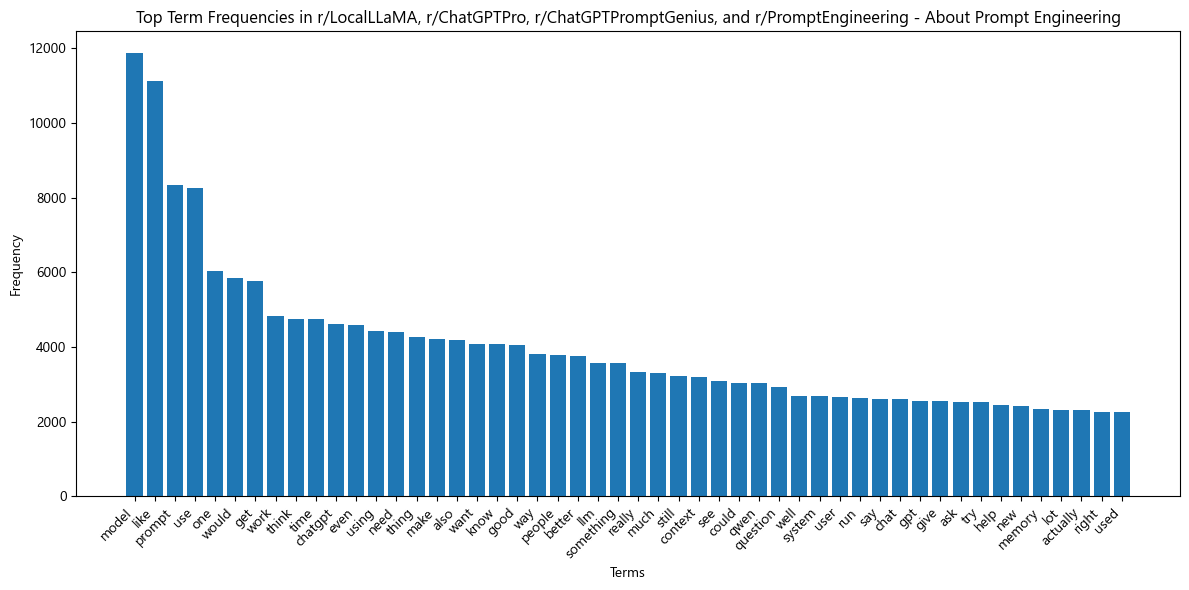

In [4]:
from collections import Counter

freqNum = 50  # Define the number of most frequent terms to show
termFreqCounter = Counter()

# Count terms directly from preprocessed tokens
for item in preprocessed_data:
    termFreqCounter.update(item['tokens'])

# Print top terms
for term, count in termFreqCounter.most_common(freqNum):
    print(f"{term}: {count}")

# Plotting
y = [count for term, count in termFreqCounter.most_common(freqNum)]
x = range(1, len(y) + 1)
terms = [term for term, count in termFreqCounter.most_common(freqNum)]

plt.figure(figsize=(12, 6))
plt.bar(terms, y)
plt.xticks(rotation=45, ha='right')
plt.title("Top Term Frequencies in r/LocalLLaMA, r/ChatGPTPro, r/ChatGPTPromptGenius, and r/PromptEngineering - About Prompt Engineering")
plt.ylabel("Frequency")
plt.xlabel("Terms")
plt.tight_layout()
plt.show()

## Sentiment Analysis using Vader

Compute the sentiment using the Vader method.

In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Function for sentiment analysis (VADER)
def analyze_sentiment(text):
    # VADER sentiment analysis (returns a dictionary of sentiment scores)
    return sia.polarity_scores(text)

# Process sentiment for preprocessed data
sentiment_results = []

for submission in preprocessed_data:
    text = submission['text']
    sentiment = analyze_sentiment(text)
    
    sentiment_results.append({
        "type": submission["type"],
        "date": submission["date"],
        "text": text,
        "sentiment_compound": sentiment["compound"],
        "sentiment_pos": sentiment["pos"],
        "sentiment_neu": sentiment["neu"],
        "sentiment_neg": sentiment["neg"]
    })

### Time Series of Sentiment

Now we look at a time series displaying the total and average sentiment of the reddit data by both day and hour, to get a visualisation of of how the total sentiment has changed over time. We also look at a time series displaying the average sentiment of the reddit data by both day and hour, to get a visualisation of of how the average sentiment (general mood) has changed over time. 

<Figure size 1000x500 with 0 Axes>

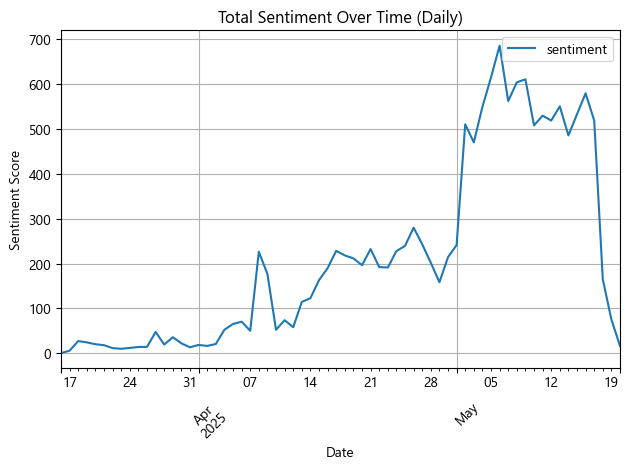

<Figure size 1000x500 with 0 Axes>

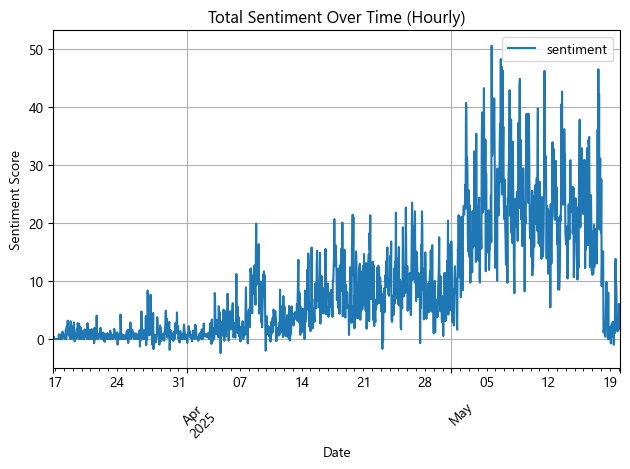

<Figure size 1000x500 with 0 Axes>

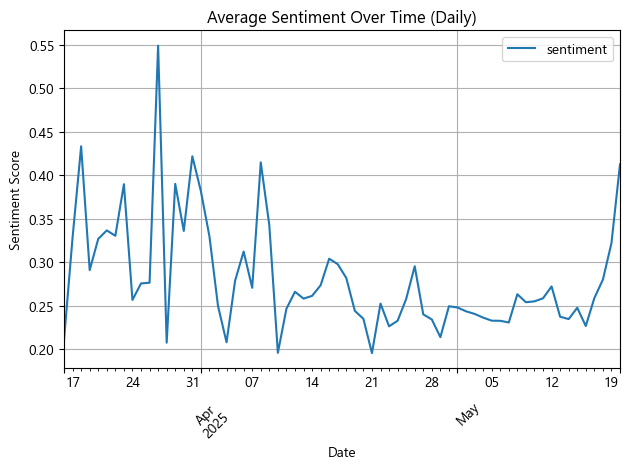

<Figure size 1000x500 with 0 Axes>

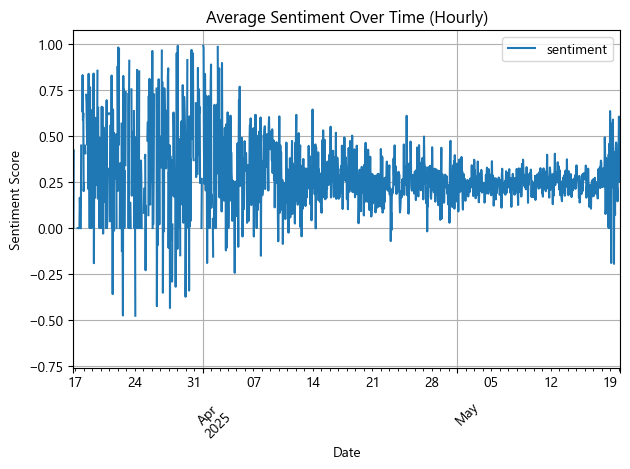

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming sentiment_results is already populated and structured
lSentiment = [(entry['date'], entry['sentiment_compound']) for entry in sentiment_results]

# Convert to DataFrame
series = pd.DataFrame(lSentiment, columns=['date', 'sentiment'])

# Set 'date' as the index
series.set_index('date', inplace=True)

# Ensure sentiment is numeric
series['sentiment'] = pd.to_numeric(series['sentiment'])

# Sort by date for good measure
series.sort_index(inplace=True)

# --- 1. Total Sentiment Over Time (Daily) ---
daily_series_sum = series.resample('1D').sum()
plt.figure(figsize=(10, 5))
daily_series_sum.plot()
plt.title("Total Sentiment Over Time (Daily)")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# --- 2. Total Sentiment Over Time (Hourly) ---
hourly_series_sum = series.resample('1h').sum()
plt.figure(figsize=(10, 5))
hourly_series_sum.plot()
plt.title("Total Sentiment Over Time (Hourly)")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# --- 3. Average Sentiment Over Time (Daily) ---
daily_series_avg = series.resample('1D').mean()
plt.figure(figsize=(10, 5))
daily_series_avg.plot()
plt.title("Average Sentiment Over Time (Daily)")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# --- 4. Average Sentiment Over Time (Hourly) ---
hourly_series_avg = series.resample('1h').mean()
plt.figure(figsize=(10, 5))
hourly_series_avg.plot()
plt.title("Average Sentiment Over Time (Hourly)")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show all plots
plt.show()

### Topic Modelling (LDA) method

First we set the parameters of our topic model.

In [7]:
# set parameters
topicNum = 5              # Number of topics
wordNumToDisplay = 15     # Words to display per topic
featureNum = 1500         # Vocabulary size

Next we transform the preprocessed text data into a matrix of word counts, selecting the most relevant words based on frequency thresholds for further analysis.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# Join tokens into strings for vectorizer
joined_docs = [' '.join(entry['tokens']) for entry in preprocessed_data]

# Create CountVectorizer with your params
tfVectorizer = CountVectorizer(
    max_df=0.95,
    min_df=2,
    max_features=featureNum,
)

# Apply vectorizer
tf = tfVectorizer.fit_transform(joined_docs)
tfFeatureNames = tfVectorizer.get_feature_names_out()

Now its time to train our LDA model

In [9]:
# Train LDA Model
from sklearn.decomposition import LatentDirichletAllocation

ldaModel = LatentDirichletAllocation(
    n_components=topicNum,
    max_iter=10,
    learning_method='online',
    random_state=42
).fit(tf)

After we have trained our LDA model, we can display the identified topics.

In [10]:
# Display the topics
def display_topics(model, featureNames, numTopWords):
    for topicId, lTopicDist in enumerate(model.components_):
        print(f"\nTopic {topicId + 1}:")
        print(" ".join([featureNames[i] for i in lTopicDist.argsort()[:-numTopWords - 1:-1]]))

display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)


Topic 1:
like thanks would one work use using really free got good also great llama get

Topic 2:
model get think much want need thing still know time one like would code make

Topic 3:
like chatgpt human real language people question feel one self someone even idea word system

Topic 4:
qwen pro that run gemini stuff lol gpu coding good better vram there cpu look

Topic 5:
prompt model use context user output llm token using example text tool data system research


Now we Create our Interactive pyLDAvis Panel to further explore our topics in detail.

In [11]:
# Create our Interactive pyLDAvis Panel
import pyLDAvis
import pyLDAvis.lda_model

panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

C:\Users\Julian Schmidt-Heron\anaconda3\envs\tf_env\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


We will also display the word clouds of our identified topics, to get a good visualisation of our topics. The more prominent a word is in the topic, the larger the word will appear.

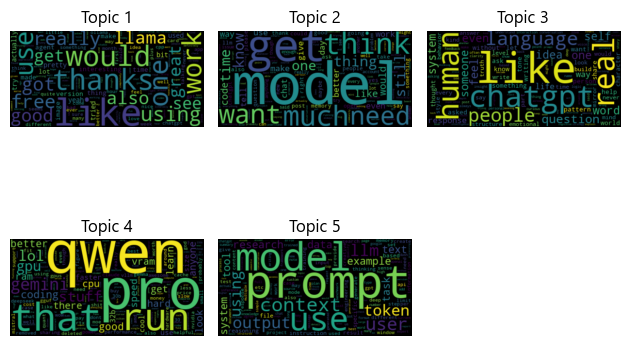

In [17]:
# Display Wordclouds
import numpy as np
import math
from wordcloud import WordCloud

def displayWordcloud(model, featureNames):
    normalisedComponents = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    plotColNum = 3
    plotRowNum = int(math.ceil(len(model.components_) / plotColNum))

    for topicId, lTopicDist in enumerate(normalisedComponents):
        lWordProb = {featureNames[i]: prob for i, prob in enumerate(lTopicDist)}
        wordcloud = WordCloud(background_color='black')
        wordcloud.fit_words(frequencies=lWordProb)

        plt.subplot(plotRowNum, plotColNum, topicId + 1)
        plt.title(f'Topic {topicId + 1}')
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

    plt.tight_layout()
    plt.show()

displayWordcloud(ldaModel, tfFeatureNames)

## Social Network Analysis: Identifying Influential Users and Structural Properties

In this section, we analyze the Reddit reply network to identify key users and understand the structure of online interactions using centrality metrics and other network features.

Load the saved reply graph from a GraphML file for further network analysis.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Load your Reddit reply network
sFileName = "reddit_reply_network.graphml"
replyGraph = nx.readwrite.read_graphml(sFileName)

Clean the graph, retain the largest strongly connected component, and calculate three centrality metrics to find key users.

In [2]:
# Remove isolated nodes (users with no replies in or out)
isolated_nodes = list(nx.isolates(replyGraph))
replyGraph.remove_nodes_from(isolated_nodes)

# If not strongly connected, keep the largest strongly connected component
if not nx.is_strongly_connected(replyGraph):
    largest_scc = max(nx.strongly_connected_components(replyGraph), key=len)
    replyGraph = replyGraph.subgraph(largest_scc).copy()

# Centrality Measures
lDegCentrality = nx.degree_centrality(replyGraph)
lEigenVectorCentrality = nx.eigenvector_centrality(replyGraph, max_iter=5000, tol=1e-6)
#lKatzCentrality = nx.katz_centrality(replyGraph, max_iter=5000, tol=1e-3)

# Display top 5 users for each centrality
print("Top 5 users by Degree Centrality:", sorted(lDegCentrality.items(), key=lambda x: x[1], reverse=True)[:5])
print("Top 5 users by Eigenvector Centrality:", sorted(lEigenVectorCentrality.items(), key=lambda x: x[1], reverse=True)[:5])
#print("Top 5 users by Katz Centrality:", sorted(lKatzCentrality.items(), key=lambda x: x[1], reverse=True)[:5])

Top 5 users by Degree Centrality: [('None', 0.14622381477398017), ('AppearanceHeavy6724', 0.05429988974641676), ('axw3555', 0.04230981256890849), ('Zestyclose-Pay-9572', 0.0337651598676957), ('Tall_Ad4729', 0.031422271223814774)]
Top 5 users by Eigenvector Centrality: [('None', 0.4688898981723629), ('AppearanceHeavy6724', 0.21831777538781386), ('a_beautiful_rhind', 0.14077418891186716), ('silenceimpaired', 0.11908660949034691), ('jacek2023', 0.11137077945185125)]


Plot histograms to visualize the distribution of centrality scores across all users in the network.

"\nplt.subplot(1, 3, 3)\nplt.hist(list(lKatzCentrality.values()))\nplt.title('Katz Centrality')\nplt.xlabel('Centrality')\n\nplt.tight_layout()\nplt.show()\n"

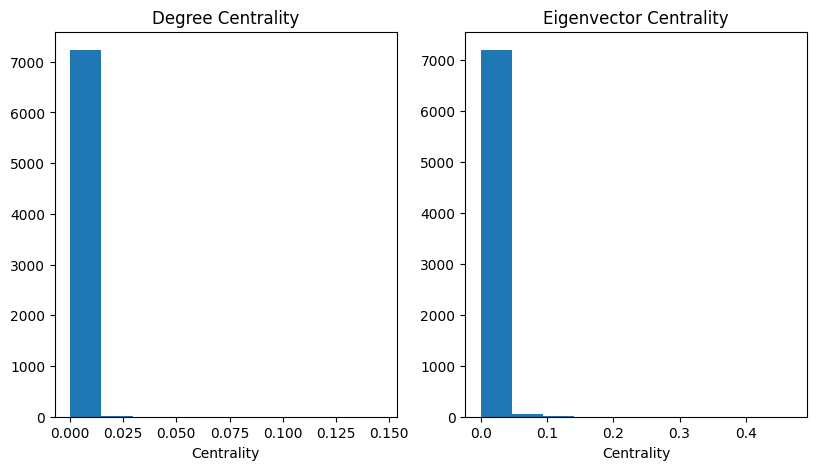

In [3]:
# Plot histograms of the centrality measures
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(list(lDegCentrality.values()))
plt.title('Degree Centrality')
plt.xlabel('Centrality')

plt.subplot(1, 3, 2)
plt.hist(list(lEigenVectorCentrality.values()))
plt.title('Eigenvector Centrality')
plt.xlabel('Centrality')
"""
plt.subplot(1, 3, 3)
plt.hist(list(lKatzCentrality.values()))
plt.title('Katz Centrality')
plt.xlabel('Centrality')

plt.tight_layout()
plt.show()
"""

Annotate the graph with centrality scores and save it for further visualization in Gephi.

In [5]:
# Store centrality values into node attributes for Gephi export
for nodeId, val in lEigenVectorCentrality.items():
    replyGraph.nodes[nodeId]['eigen'] = float(val)
    """
for nodeId, val in lKatzCentrality.items():
    replyGraph.nodes[nodeId]['katz'] = float(val)
"""
# Save modified graph
nx.readwrite.write_graphml(replyGraph, 'mod_' + sFileName, infer_numeric_types=True)

Compute clustering and connected component statistics to understand the network's structure and cohesion.

In [6]:
# Other SNA measures
print('Global clustering coefficient (transitivity):', nx.transitivity(replyGraph))
print('Number of strongly connected components:', nx.number_strongly_connected_components(replyGraph))
print('Number of weakly connected components:', nx.number_weakly_connected_components(replyGraph))

Global clustering coefficient (transitivity): 0.01790303299283449
Number of strongly connected components: 1
Number of weakly connected components: 1


Detect bridge edges whose removal could split the network, highlighting critical connections between subgroups.

In [7]:
# Bridges (edges that if removed would disconnect the graph)
bridges = list(nx.bridges(replyGraph.to_undirected()))
print(f"Bridges found ({len(bridges)}):", bridges)

Bridges found (1941): [('tangoshukudai', 'un-realestate'), ('MindOrbits', 'RedQueenNatalie'), ('MindOrbits', 'Major-Excuse1634'), ('waiting_for_zban', 'SummerElectrical3642'), ('Lalith24', 'julius8686'), ('RiverGateExpress', 'Tycoon33'), ('TheCowprinter', 'shezboy'), ('Additional-Bat-3623', 'Double_Cause4609'), ('ResponsibilityOk2173', 'thejay2009'), ('SecretaryActual5093', 'Serious-Put6732'), ('rhoadss', 'MironPuzanov'), ('StudentModern', 'FrankFace81'), ('Sidran', 'DashinTheFields'), ('PresentationSame1738', 'performanceboner'), ('Logical-Control2934', 'KrustenStewart'), ('logosobscura', 'Zestyclose-Pay-9572'), ('mxforest', 'LumpyWelds'), ('No_Highlight1148', 'Kirys79'), ('ThatsAPizza53', 'Single_Ad2713'), ('pfire777', 'Royal-Being1822'), ('Cledwards99', 'Historical-Internal3'), ('Yarnbomb72', 'AmberFlux'), ('CoopaScoopa', 'Oldschool728603'), ('moiz9900', 'mishkaforest235'), ('cualquiera01', 'AppointmentSubject25'), ('Standard-Potential-6', 'Pristine-Woodpecker'), ('Ghaith97', 'Shloo

What the Output Tells You

Interpreting the Output:
Top Users by Centrality:
This shows you the most active or influential users based on the network structure. These users play a central role in discussions and interactions.

Histograms:
The histograms help visualize the distribution of centrality values. This gives you insight into whether power is equally distributed across users, or if a few users dominate the network.

Clustering Coefficient:
The clustering coefficient tells you how community-like the network is. Higher values indicate that users tend to interact with each other in tighter-knit subgroups (communities).

Connected Components:
This metric shows how connected or fragmented your network is. A single large connected component means the network is mostly connected, while many small components indicate fragmentation.

Bridges:
Bridges are key connections between parts of the network. These edges are critical, and removing them could break the network into isolated segments. Identifying bridges helps understand the network’s vulnerability.